In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OUTPUT_DF_DIR = os.path.join(OUTPUT_DIR,"DATAFRAME")


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
data_ver = 40
train = pd.read_csv(os.path.join(OUTPUT_DF_DIR,f"exp{data_ver}_train.csv"))
test = pd.read_csv(os.path.join(OUTPUT_DF_DIR,f"exp{data_ver}_test.csv"))
features_df = pd.read_csv(os.path.join(OUTPUT_DF_DIR,f"exp{data_ver}_imp.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,86,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(14140, 3475)


,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,year-month,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7
0,4299,24.354412,124.202036,20.0,1999.11.8,1999.0,11.0,0.150,0.3305,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
1,10451,24.351580,124.200529,20.0,1999.11.7,1999.0,11.0,0.200,1.6946,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1
2,13086,24.350239,124.203270,20.0,1999.11.8,1999.0,11.0,0.125,1.4239,0.0,...,1999-11-01,1,999,1,1,1,1,1,1,1


(4039, 3475)


,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,year-month,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,NaN,0.5000,0.000000,...,2002-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,9.0693,0.000000,...,2010-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,13.8000,73.183418,...,2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
features = features_df[:35].feature.tolist()
target = "cover"

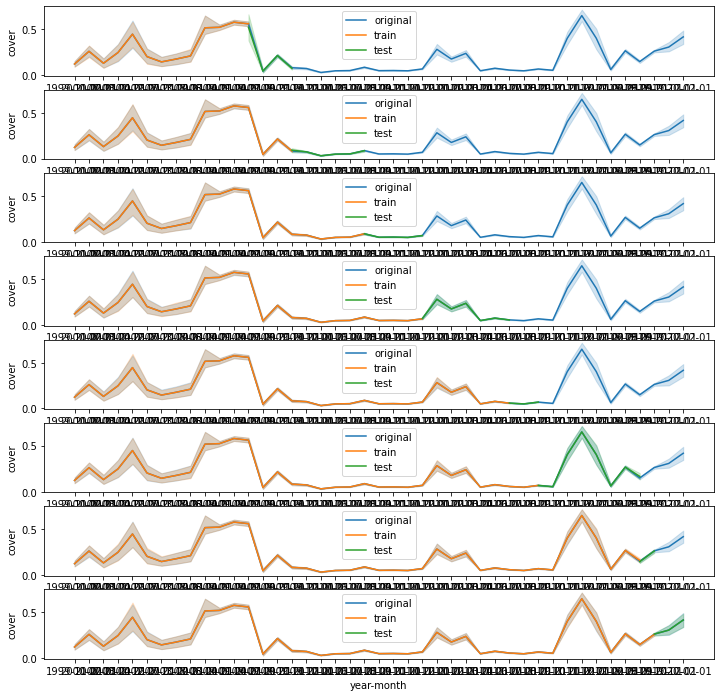

In [6]:
fig, axes = plt.subplots(8, 1, figsize=(12, 12))


for fold in range(8):

    sns.lineplot(data=train, x='year-month', y='cover', ax=axes[fold], label='original')
    # 学習用データを描く
    sns.lineplot(data=train[train[f'tr_fold{fold}'] == 1], x='year-month', y='cover', ax=axes[fold], label='train')
    # テスト用データを描く
    sns.lineplot(data=train[train['va_fold'] == fold], x='year-month', y='cover', ax=axes[fold], label='test')

# グラフを表示する
plt.legend()
plt.show()

## Model

In [7]:
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.decomposition import TruncatedSVD

In [8]:
class CFG:
  debug=False
  ver=42
  model="knn"
  n_folds=8
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7]
  seed=42
  target_cols="cover"
  N_COMPONENTS=8
  n_neighbors=1

In [9]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [10]:
def get_pred(df, test, target_cols, model):

  oof_df = pd.DataFrame()
  test_preds = np.zeros((len(test), CFG.n_folds))
  svd = TruncatedSVD(n_components=CFG.N_COMPONENTS, random_state=CFG.seed)

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_X = svd.fit_transform(train_X)
      valid_X = svd.transform(valid_X)
      test_X = svd.transform(test_X)
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      clf.fit(train_X, train_labels)
      
      valid_folds[f"pred"] = model.predict(valid_X)
      test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])


      get_score(valid_labels, valid_folds[f"pred"])

  return oof_df,  test_preds

In [11]:
%%time
if CFG.debug:
  print(train.shape)
  train = train.sample(n=200, random_state=CFG.seed).reset_index(drop=True)
  train = train.sort_values("year-month").reset_index(drop=True)
  print(train.shape)

model = KNeighborsRegressor(n_neighbors=CFG.n_neighbors)
oof_df, test_pred = get_pred(train, test, CFG.target_cols, model)

===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年7.0月
valid period : 2009.0年7.0月 ～ 2009.0年11.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.3601553165324637
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年11.0月
valid period : 2009.0年11.0月 ～ 2010.0年8.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.15966418259288892
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年12.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.1361009636653252
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年7.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.18221137769546789
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.08950870217891832
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2019.0年9.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.25528369981296756
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.3639257011768812
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月


<ipython-input-10-c43dad9cc609>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = model.predict(valid_X)


RMSE 0.17076493199344803
CPU times: user 4.46 s, sys: 10.8 s, total: 15.3 s
Wall time: 4 s


In [12]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.23507771003793487


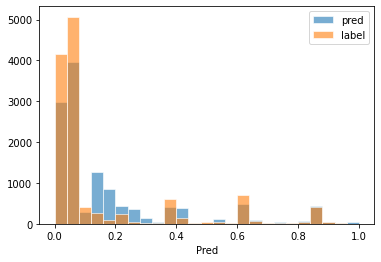

In [13]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [14]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,NaN,0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200000
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,9.069300,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089375
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,13.800000,73.183418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375000
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,7.629000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061450
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,NaN,-0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,NaN,0.400000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268750
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,10.345033,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308325
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,0.100000,76.439651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020000
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,5.069000,73.660492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143750


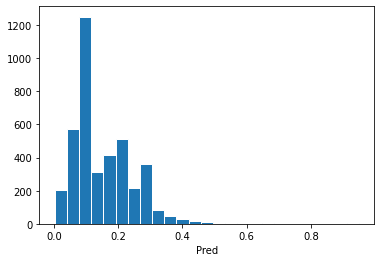

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,tr_fold0,va_fold,tr_fold1,tr_fold2,tr_fold3,tr_fold4,tr_fold5,tr_fold6,tr_fold7,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,NaN,0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200000
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,9.069300,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089375
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,13.800000,73.183418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375000
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,7.629000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.061450
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,NaN,-0.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,NaN,0.400000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.268750
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,10.345033,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308325
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,NaN,0.100000,76.439651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020000
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,5.069000,73.660492,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.143750


In [15]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)